# <h1><b><I> General Setup

## Imports and general setup

In [1]:
import os, sys, time
from scipy import interpolate, special, integrate

sys.path.append("..")
sys.path.append("../gammabayes")
sys.path.append("../gammabayes/dark_matter/")


from gammabayes.hyper_inference.hyperparameter_likelihood import hyperparameter_likelihood
from gammabayes.priors.prior import discrete_logprior
from gammabayes.dark_matter.SS_DM_Construct import SS_DM_dist
from gammabayes.utils.utils import bkgdist
from gammabayes.utils.utils import makelogjacob
from gammabayes.utils.utils import single_likelihood
from gammabayes.utils.config_utils import read_config_file, create_true_axes_from_config, create_recon_axes_from_config


import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools, multiprocessing, yaml
from multiprocessing import Pool, freeze_support
import pandas as pd




/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Script Parameter Setup

In [2]:
startertimer = time.perf_counter()
print(startertimer)

config_inputs = read_config_file('example_config_file.yaml')

nsig                = int(round(config_inputs['xi']*config_inputs['Nevents']))
nbkg                = int(round((1-config_inputs['xi'])*config_inputs['Nevents']))



2.978052209
config file path: example_config_file.yaml


# <h1><b>Simulation Result Loading

In [3]:


log10_eaxis_true, longitude_axis_true, latitude_axis_true = create_true_axes_from_config(config_inputs)
log10_eaxis, longitude_axis, latitude_axis = create_recon_axes_from_config(config_inputs)
log10_mass = config_inputs['logmass']


log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10_eaxis_true, longitude_axis_true, latitude_axis_true, indexing='ij')
lonmeshtrue, latmeshtrue = np.meshgrid(longitude_axis_true, latitude_axis_true, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitude_axis, latitude_axis, indexing='ij')
logjacobtrue = np.meshgrid(np.log(10**log10_eaxis_true), longitude_axis_true, latitude_axis_true, indexing='ij')[0]


print(log10_eaxis_true.shape, longitude_axis_true.shape, latitude_axis_true.shape)


-0.5 1.5 300 0.2 -3.5 3.5 -3.1 3.1
-0.5 1.5 50 0.4 -3.5 3.5 -3.1 3.1
(601,) (36,) (32,)


In [4]:

SS_DM_dist_instance= SS_DM_dist(longitude_axis_true, latitude_axis_true)#, density_profile=config_inputs['dmdensity_profile'])
logDMpriorfunc = SS_DM_dist_instance.func_setup()

logjacob_true = np.meshgrid(makelogjacob(log10_eaxis_true), longitude_axis_true, latitude_axis_true, indexing='ij')[0]

DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10_eaxis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['log10 energy', 'lon', 'lat'],
                               default_hyperparameter_values=(log10_mass,), 
                               hyperparameter_names=['mass'], logjacob=logjacob_true)
DM_prior

(1.0,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x7f97183f9af0>
input units of None
over axes ['log10 energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

In [5]:
sys.path.append('..')

from gammabayes.utils.utils import bkgdist
from scipy import special, interpolate
from gammabayes.utils.default_file_setup import default_file_setup

nuisancemesh = np.meshgrid(log10_eaxis_true, longitude_axis_true, latitude_axis_true, indexing='ij')

astrophysicalbackground = default_file_setup(setup_astrobkg=1, setup_irfnormalisations=0,
                                log10eaxistrue=log10_eaxis_true, longitudeaxistrue=longitude_axis_true, latitudeaxistrue=latitude_axis_true, 
                                save_results=False, outputresults=True)
unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))


logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues+logjacob_true)

logbkgpriorvalues.shape




unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(*nuisancemesh)),np.log(astrophysicalbackground))
# unnormed_logbkgpriorvalues = np.squeeze(bkgdist(*nuisancemesh))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10_eaxis_true, longitude_axis_true, latitude_axis_true,), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10_eaxis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['log10 energy', 'lon', 'lat'], logjacob=logjacob_true)

bkg_prior

-1.0 2.0 200 0.2 -3.5 3.5 -3.0 3.0
-1.0 2.0 50 0.4 -3.5 3.5 -3.0 3.0
Setting up the astrophysical background


Setting up HESS sources



/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)



There are 96 sources in total within the HGPS.


discrete log prior class
----------------------------
name = Background Prior
logfunction type is <function <lambda> at 0x7f9739a0ee50>
input units of None
over axes ['log10 energy', 'lon', 'lat']
with hyperparameter(s) [None]

In [6]:
psfnormalisationvalues, edispnormalisationvalues = default_file_setup(setup_astrobkg=0, setup_irfnormalisations=1,
                                log10eaxistrue=log10_eaxis_true, longitudeaxistrue=longitude_axis_true, latitudeaxistrue=latitude_axis_true, 
                                save_results=False, outputresults=True)

Setting up edisp normalisation: 100%|█████████| 601/601 [00:25<00:00, 23.33it/s]


In [7]:
bkg_log10e_measured, bkg_lon_measured, bkg_lat_measured = np.load(f'tutorial_data/recon_bkg_samples.npy')
signal_log10e_measured, signal_lon_measured, signal_lat_measured = np.load(f'tutorial_data/recon_sig_samples.npy')

try:
    measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
    measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)
    
except:
    if type(bkg_log10e_measured)==np.float64:
        measured_log10e = list(signal_log10e_measured)
        measured_lon = list(signal_lon_measured)
        measured_lat = list(signal_lat_measured)
        measured_log10e.append(bkg_log10e_measured)
        measured_lon.append(bkg_lon_measured)
        measured_lat.append(bkg_lat_measured)
        
    elif type(signal_log10e_measured)==np.float64:
        measured_log10e = list(bkg_log10e_measured)
        measured_lon = list(bkg_lon_measured)
        measured_lat = list(bkg_lat_measured)
        measured_log10e.append(signal_log10e_measured)
        measured_lon.append(signal_lon_measured)
        measured_lat.append(signal_lat_measured)
    else:
        print('what')

# <h1><b>Analysis

## Marginalisation

In [8]:


logmasswindowwidth      = 12/np.sqrt(config_inputs['xi']*config_inputs['totalevents'])

logmasslowerbound       = config_inputs['logmass']-logmasswindowwidth
logmassupperbound       = config_inputs['logmass']+logmasswindowwidth

# if 1:
if logmasslowerbound<log10_eaxis_true[0]:
    logmasslowerbound = log10_eaxis_true[0]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, config_inputs['nbins_logmass']) 

In [9]:
hyperparameter_likelihood_instance = hyperparameter_likelihood(
                                                               priors=(DM_prior, bkg_prior,), likelihood=single_likelihood, 
                                                               dependent_axes=(log10_eaxis_true,  longitude_axis_true, latitude_axis_true), 
                                                               dependent_logjacob=logjacob_true,
                                                               hyperparameter_axes = ((logmassrange,), (None,)), numcores=config_inputs['numcores'], likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)

measured_log10e = [float(measured_log10e_val) for measured_log10e_val in measured_log10e]
margresults = hyperparameter_likelihood_instance.nuisance_log_marginalisation(
    axisvals= (measured_log10e, measured_lon, measured_lat),)

Setting up prior matrices: 100%|██████████████████| 2/2 [02:52<00:00, 86.38s/it]
Performing parallelized direct event marginalisation: 100%|██████████| 1000/1000 [00:00<00:00, 1134822.51it/s]
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/docs/../gammabayes/utils/utils.py:186: RuntimeWarning: divide by zero encountered in log
  output = np.log(psffull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/docs/../gammabayes/utils/utils.py:190: RuntimeWarning: divide by zero encountered in log
  output+=np.log(edispfull.evaluate(energy_true=10**logetrue*u.TeV,


In [10]:
margresultsarray = np.array(margresults)
sigmargresults = np.squeeze(np.vstack(margresultsarray[:,0])).T
bkgmargresults = np.squeeze(np.vstack(margresultsarray[:,1]))
sigmargresults.shape

(101, 1000)

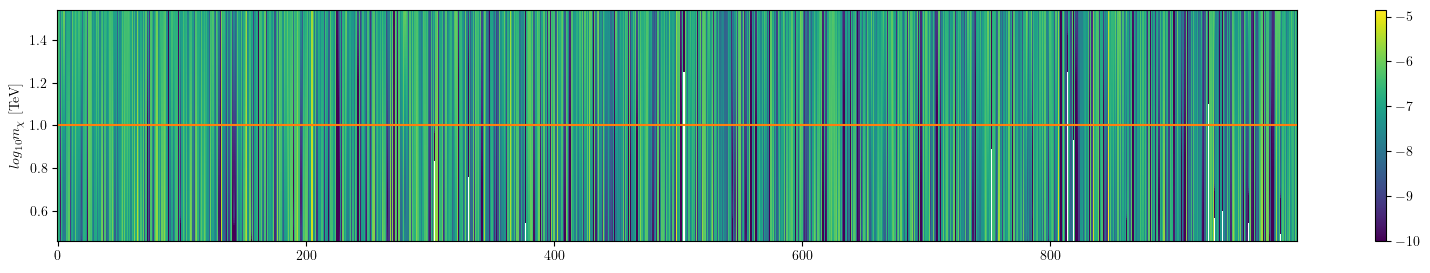

In [11]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(config_inputs['Nevents'])), logmassrange, indexing='ij'), 
               sigmargresults.T-special.logsumexp(sigmargresults, axis=1), 
               cmap='viridis', vmin=-10)
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(config_inputs['logmass'], c='tab:orange')
plt.colorbar()
plt.show()

## Calculating posterior

In [12]:
lambdawindowwidth      = 6/np.sqrt(config_inputs['totalevents'])


lambdalowerbound       = config_inputs['xi']-lambdawindowwidth
lambdaupperbound       = config_inputs['xi']+lambdawindowwidth




if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, config_inputs['nbins_xi']) 

original_log_posterior = []

for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
    original_log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+sigmargresults[logmassindex,:], np.log(1-lambdaval)+bkgmargresults)) for logmassindex in range(len(list(logmassrange)))])

original_log_posterior = np.array(original_log_posterior)-special.logsumexp(original_log_posterior)
new_log_posterior = hyperparameter_likelihood_instance.create_mixture_log_hyperparameter_likelihood(
    mixture_axes=(lambdarange, 1-lambdarange), log_marg_results=margresultsarray)

new_log_posterior = new_log_posterior - special.logsumexp(new_log_posterior)

endertimer = time.perf_counter()
print(endertimer-startertimer)

100%|██████████| 161/161 [00:00<00:00, 271.53it/s]


Reshaped mixture shape: (2, 1000)
608.823625416


In [13]:
log_posterior=np.squeeze(new_log_posterior)
# log_posterior = original_log_posterior

# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_89631/367797988.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


0.004499999999999999
0.0029999999999999983
0.0014999999999999992
0.001500000000000001
0.003000000000000002
0.004350000000000003


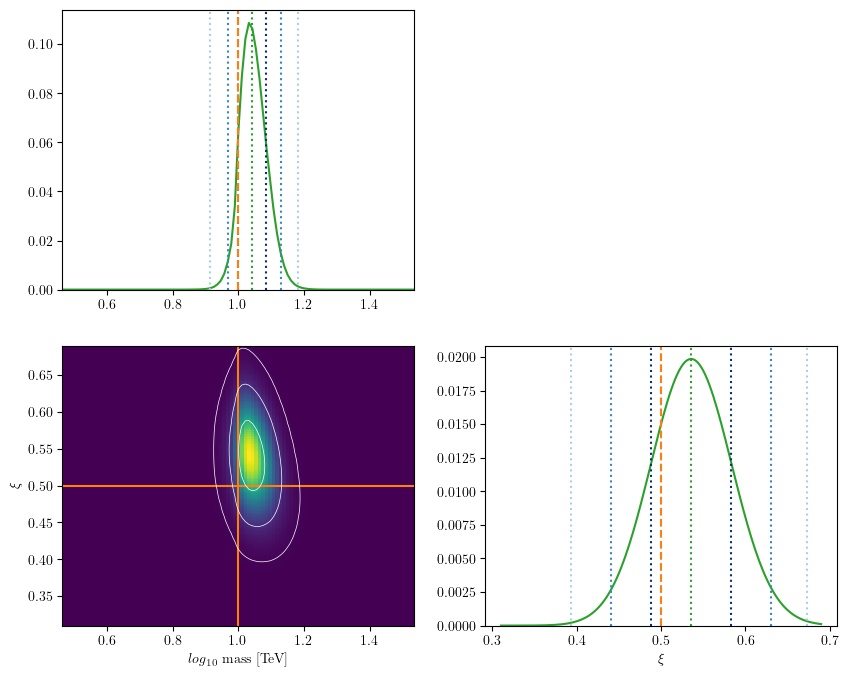

In [14]:
%matplotlib inline

from scipy.stats import norm


colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))

# Upper left plot
logmass_logposterior = special.logsumexp(log_posterior, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(config_inputs['logmass'], ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10_eaxis_true[1]-log10_eaxis_true[0]:
    for logetrueval in log10_eaxis_true:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(log_posterior), vmin=0)
ax[1,0].axvline(config_inputs['logmass'], c='tab:orange')
ax[1,0].axhline(config_inputs['xi'], c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\xi$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
normed_posterior = np.exp(log_posterior)/np.exp(log_posterior).sum()
n = 100000
t = np.linspace(0, normed_posterior.max(), n)
integral = ((normed_posterior >= t[:, None, None]) * normed_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(normed_posterior, t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


lambda_logposterior = special.logsumexp(log_posterior, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlambda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()]
    lambdapercentiles.append(lambdapercentile)
    print(np.sqrt(1e5/1e8)*np.abs(lambdapercentile - meanlambda))





ax[1,1].plot(lambdarange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(config_inputs['xi'], ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\xi$')
ax[1,1].set_ylim([0, None])


# plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{config_inputs['logmass']}_l{config_inputs['xi']}_%m%d_%H%M.pdf"))
plt.show()

In [15]:
os.system('say Your code is finished.')


0